In [29]:
#%matplotlib inline
# 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。
import matplotlib_inline
import matplotlib.pyplot as plt
import IPython.display
import random
import torch

# w = [2, -3.4]^T ,b = 4.2

In [30]:
def synthetic_data(w, b, num_example):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_example, len(w)))  # 生成均值为0，标准差为1的随机数，行数为样本数，列数为w的长度
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 随机噪声
    return X, y.reshape((-1, 1))  # 将y返回成列向量

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [31]:
print('features:', features[0], '\nlabels:', labels[0])

features: tensor([0.9711, 0.7959]) 
labels: tensor([3.4458])


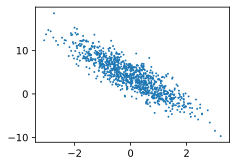

In [32]:
#IPython.display.set_matplotlib_formats('svg')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = (3.5, 2.5)
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)  # scatter散点图

In [33]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #这些样本都是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        # print(indices[:11])
        # print(indices[i:min(i+batch_size, num_examples)])
        # print(indices[min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break  # 第一次迭代后就停止

tensor([[ 0.2771,  0.0629],
        [-0.0679,  0.1964],
        [-1.1236, -0.6120],
        [ 2.8438, -0.6955],
        [-0.8329,  0.2776],
        [-0.1869,  0.0618],
        [-2.1234, -0.6527],
        [-1.5593,  0.1536],
        [ 0.5824, -1.6360],
        [-0.1029, -0.4784]]) 
 tensor([[ 4.5453],
        [ 3.4119],
        [ 4.0306],
        [12.2484],
        [ 1.5882],
        [ 3.6329],
        [ 2.1589],
        [ 0.5668],
        [10.9136],
        [ 5.6164]])


# 定义 初始化模型参数

In [34]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(w,'\n',b)

tensor([[-0.0042],
        [-0.0062]], requires_grad=True) 
 tensor([0.], requires_grad=True)


In [35]:
def linreg(X, w, b):
    """
    线性回归模型
    """
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """
    损失函数：
    均方损失
    """
    return (y_hat - y.reshape(y_hat.shape)) **2 /2

def sgd(params, lr, batch_size):
    """
    优化算法：
    小批量随机梯度下降
    """
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad / batch_size
            param.grad.zero_()

# 训练过程

In [36]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 'X'和'y'的小批量损失
        # 因为‘l’形状是（batch_size, 1）,而不是一个标量。‘l'中的所有元素被加到。。。
        # 并以此计算关于[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034095
epoch 2, loss 0.000125
epoch 3, loss 0.000047


In [37]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0001, -0.0001], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0005], grad_fn=<RsubBackward1>)
